In [2]:
! pip install ftfy regex tqdm

In [3]:
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-35vjtyic
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-35vjtyic
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done


In [159]:
import random
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import matplotlib.pyplot as plt
import numpy as np
import tarfile
import os
from PIL import Image

from timeit import default_timer as timer
from tqdm.auto import tqdm
from torchvision import datasets, models, transforms
from torchsummary import summary
from typing import Callable, Dict, List, Tuple, Union
from torch.optim import lr_scheduler
# from torch.utils.tensorboard import SummaryWriter
# import skimage

import clip #importing clip model

print("Torch version:", torch.__version__)

Torch version: 2.0.0+cu117


In [160]:
device = "cpu"
if torch.cuda.is_available:
  print('cuda available')
  device = torch.device("cuda:0")
else:
  print('Please set GPU via Edit -> Notebook Settings.')

cuda available


In [161]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [209]:
model, preprocess = clip.load("ViT-B/32",jit=False) #loading the CLIP model based on ViT
model.cuda().eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [163]:
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

In [164]:
print(input_resolution)
print(context_length)
print(vocab_size)

224
77
49408


In [165]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f4253325e50>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [166]:
# 토크나이저 예시
clip.tokenize("smile")

tensor([[49406,  3490, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Zero shot downstream task

## Test on cifar100 dataset

In [167]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=False) #exploiting CLIP preprocess for dataset transformation

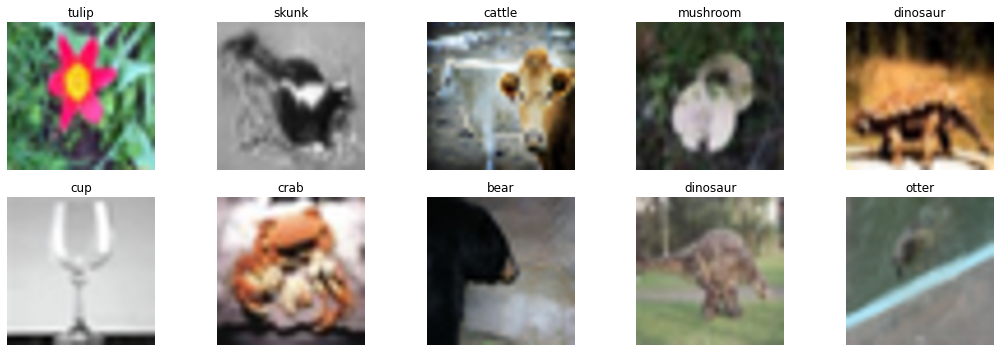

In [168]:
mean_CIFAR100 = [0.48145466, 0.4578275, 0.40821073]
std_CIFAR100 = [0.26862954, 0.26130258, 0.27577711]

class NormalizeInverse(torchvision.transforms.Normalize):
    def __init__(self, mean: List[float], std: List[float]) -> None:
        """Reconstructs the images in the input domain by inverting 
        the normalization transformation.

        Args:
            mean: the mean used to normalize the images.
            std: the standard deviation used to normalize the images.
        """
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

def show_grid(dataset: torchvision.datasets.ImageFolder, 
              process: Callable = None) -> None:
    """Shows a grid with random images taken from the dataset.

    Args:
        dataset: the dataset containing the images.
        process: a function to apply on the images before showing them.        
    """
    fig = plt.figure(figsize=(15, 5))
    indices_random = np.random.randint(10, size=10, high=len(dataset))
    #indices_random= [x for x in range(8)]

    for count, idx in enumerate(indices_random):
        fig.add_subplot(2, 5, count + 1)
        title = dataset.classes[dataset[idx][1]]
        plt.title(title)
        image_processed = process(dataset[idx][0]) if process is not None else dataset[idx][0]
        plt.imshow(transforms.ToPILImage()(image_processed))
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

denormalize = NormalizeInverse(mean_CIFAR100, std_CIFAR100)
show_grid(cifar100, process=denormalize)

In [169]:
train_set, val_set, test_set = torch.utils.data.random_split(cifar100, [40000, 8000,2000])
print(cifar100)

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: /root/.cache
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               <function _convert_image_to_rgb at 0x7f4253325e50>
               ToTensor()
               Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
           )


### Image Encoding

In [170]:
image_input = torch.tensor(np.stack([test_set[x][0] for x in range(len(test_set))])).cuda()
# Label of test dataset
labels = torch.tensor(np.stack([test_set[x][1] for x in range(len(test_set))]))
print(labels)
with torch.no_grad():
    image_features = model.encode_image(image_input).float()

tensor([26, 67, 56,  ...,  0, 78, 93])


In [171]:
text_descriptions = [f"a photo of a {label}" for label in cifar100.classes]

text_tokens_ensembled = clip.tokenize(text_descriptions).cuda()
text_tokens = clip.tokenize(cifar100.classes).cuda()

### Data ensembling and text encoding

CLIP works as a natual language supervised algorithm, given that, manipulating labels can give better results. We are going to compare the results with and without ensembling

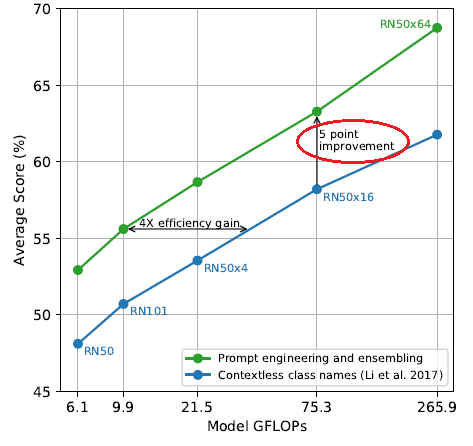

In [172]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_features_ensembled = model.encode_text(text_tokens_ensembled).float()
    text_features_ensembled /= text_features_ensembled.norm(dim=-1, keepdim=True)
#the 100.0 works as temperature parameter, raising the softmax confidence 
text_probs_notens = (100.0 * image_features @ text_features.T).softmax(dim=-1)
text_probs = ( 100.0 * image_features @ text_features_ensembled.T).softmax(dim=-1)

top_probs, top_labels = text_probs.cpu().topk(3, dim=-1)
top_probs_n, top_labels_n = text_probs_notens.cpu().topk(3, dim=-1)

### Performance : Zero shot accuracy computation

In [173]:
correct_labels = 0
correct_labels_not = 0
for index, prediction in enumerate(top_labels):
  if prediction[0]==labels[index]:
    correct_labels=correct_labels+1
for index, prediction in enumerate(top_labels_n):
  if prediction[0]==labels[index]:
    correct_labels_not=correct_labels_not+1    
print("The overall accuracy for the CLIP Zero shot model with ensembling is: {}".format((correct_labels/len(top_labels))))
print("The overall accuracy for the CLIP Zero shot model without ensembling is: {}".format((correct_labels_not/len(top_labels_n))))

print(correct_labels)
print(correct_labels_not)

The overall accuracy for the CLIP Zero shot model with ensembling is: 0.6115
The overall accuracy for the CLIP Zero shot model without ensembling is: 0.5375
1223
1075


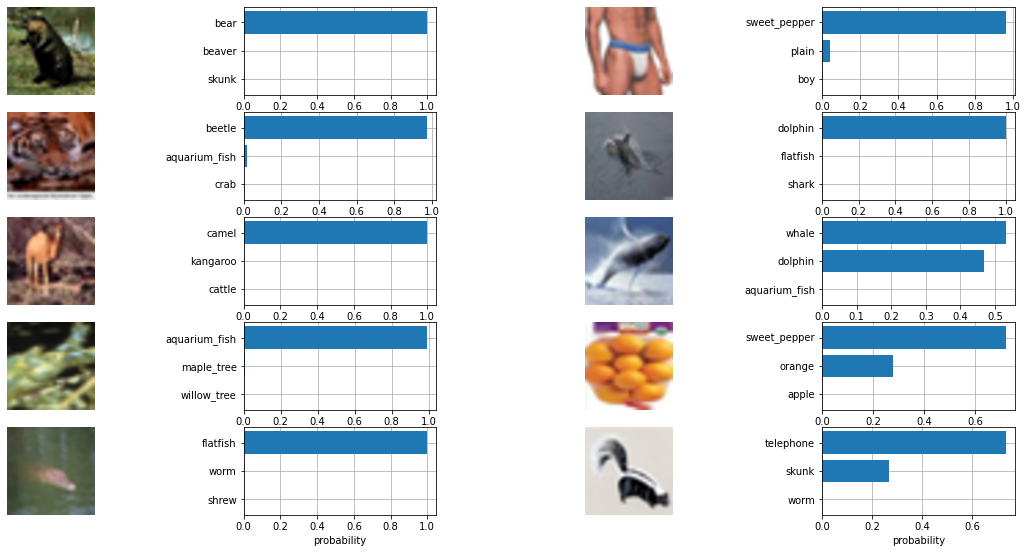

In [174]:
plt.figure(figsize=(19, 19))
#taking random index for random sampling
random_index = np.random.randint(10, size=10, high=len(image_input))
image_input_sample = [(image_input[x],x) for x in random_index] 
for i, image in enumerate(image_input_sample):
    plt.subplot(len(image_input_sample), 4, 2 * i + 1)
    #denormalizing the image and transforming to PIL image
    image_processed = denormalize(image[0].cpu())
    plt.imshow(transforms.ToPILImage()(image_processed))

    plt.axis("off")

    plt.subplot(len(image_input_sample), 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[image[1]])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[image[1]].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

## Cosmetic Dataset(Ours)

In [325]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

class NormalizeInverse(torchvision.transforms.Normalize):
    def __init__(self, mean: List[float], std: List[float]) -> None:
        """Reconstructs the images in the input domain by inverting 
        the normalization transformation.

        Args:
            mean: the mean used to normalize the images.
            std: the standard deviation used to normalize the images.
        """
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

def show_grid(dataset: torchvision.datasets.ImageFolder, 
              process: Callable = None) -> None:
    """Shows a grid with random images taken from the dataset.

    Args:
        dataset: the dataset containing the images.
        process: a function to apply on the images before showing them.        
    """
    fig = plt.figure(figsize=(15, 5))
    indices_random = np.random.randint(len(dataset), size=10)
    #indices_random= [x for x in range(8)]

    for count, idx in enumerate(indices_random):
        fig.add_subplot(2, 5, count + 1)
        title = dataset.classes[dataset[idx][1]]
        plt.title(title)
        image_processed = process(dataset[idx][0]) if process is not None else dataset[idx][0]
        plt.imshow(transforms.ToPILImage()(image_processed))
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

denormalize = NormalizeInverse(mean, std)

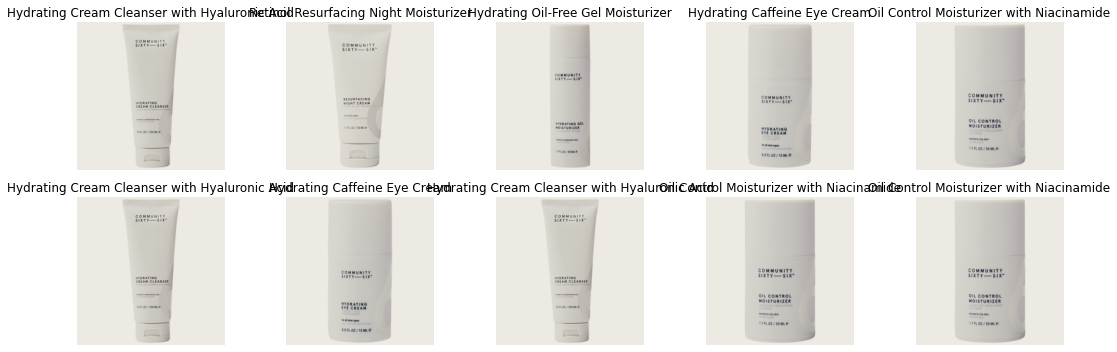

In [356]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.samples = []  # (path_to_sample, class_index) tuple 리스트를 담는 리스트
        self.classes = []  # 클래스 이름 리스트

        # root 아래의 하위 디렉토리와 파일들을 탐색하여 (path_to_sample, class_index) tuple을 samples 리스트에 추가
        for class_index, class_name in enumerate(os.listdir(root)):
            class_dir = os.path.join(root, class_name)
            if os.path.isdir(class_dir):
                self.classes.append(class_name)
                for sample_name in os.listdir(class_dir):
                    sample_path = os.path.join(class_dir, sample_name)
                    self.samples.append((sample_path, class_index))

    def __getitem__(self, index):
        path, target = self.samples[index]
        with open(path, 'rb') as f:
            sample = Image.open(f).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target

    def __len__(self):
        return len(self.samples)

data_set = CustomDataset('/workspace/data/', transform=preprocess)
train_set = CustomDataset('/workspace/data/train/', transform=preprocess)
test_set = CustomDataset('/workspace/data/test/', transform=preprocess)
show_grid(train_set, process=denormalize)

In [357]:
image_input = torch.tensor(np.stack([test_set[x][0] for x in range(len(test_set))])).cuda()
labels = torch.tensor(np.stack([test_set[x][1] for x in range(len(test_set))]))
print(labels)
with torch.no_grad():
    image_features = model.encode_image(image_input).float()

tensor([1, 1, 1, 1, 1, 2, 2, 2, 2, 2])


In [358]:
# text_descriptions = [f"The name of product is {label} and it is written in black on the package. All the packages are white colour" for label in train_set.classes]
text_descriptions = [f"a product of {label}" for label in train_set.classes]

print(text_descriptions)

# text descriptions 활용
text_tokens_ensembled = clip.tokenize(text_descriptions).cuda()
# 클래스 이름 활용
text_tokens = clip.tokenize(train_set.classes).cuda()

['a product of Hydrating Cream Cleanser with Hyaluronic Acid', 'a product of Hydrating Oil-Free Gel Moisturizer', 'a product of Everyday Mineral Moisturizer SPF 30 Sunscreen', 'a product of Oil Control Moisturizer with Niacinamide', 'a product of Retinol Resurfacing Night Moisturizer', 'a product of Nourishing Rich Moisturizer with Hyaluronic Acid', 'a product of Hydrating Caffeine Eye Cream', 'a product of Makeup Melting Balm Cleanser']


In [359]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_features_ensembled = model.encode_text(text_tokens_ensembled).float()
    text_features_ensembled /= text_features_ensembled.norm(dim=-1, keepdim=True)
#the 100.0 works as temperature parameter, raising the softmax confidence 
text_probs_notens = (100.0 * image_features @ text_features.T).softmax(dim=-1)
text_probs = ( 100.0 * image_features @ text_features_ensembled.T).softmax(dim=-1)

top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)
top_probs_n, top_labels_n = text_probs_notens.cpu().topk(5, dim=-1)

In [362]:
correct_labels = 0
correct_labels_not = 0
for index, prediction in enumerate(top_labels):
  if prediction[0]==labels[index]:
    correct_labels=correct_labels+1
    print(labels[index])
for index, prediction in enumerate(top_labels_n):
  if prediction[0]==labels[index]:
    correct_labels_not=correct_labels_not+1    
print("The overall accuracy for the CLIP Zero shot model with ensembling is: {}".format((correct_labels/len(top_labels))))
print("The overall accuracy for the CLIP Zero shot model without ensembling is: {}".format((correct_labels_not/len(top_labels_n))))

print(correct_labels)
print(correct_labels_not)

tensor(1)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
The overall accuracy for the CLIP Zero shot model with ensembling is: 0.5
The overall accuracy for the CLIP Zero shot model without ensembling is: 0.4
5
4


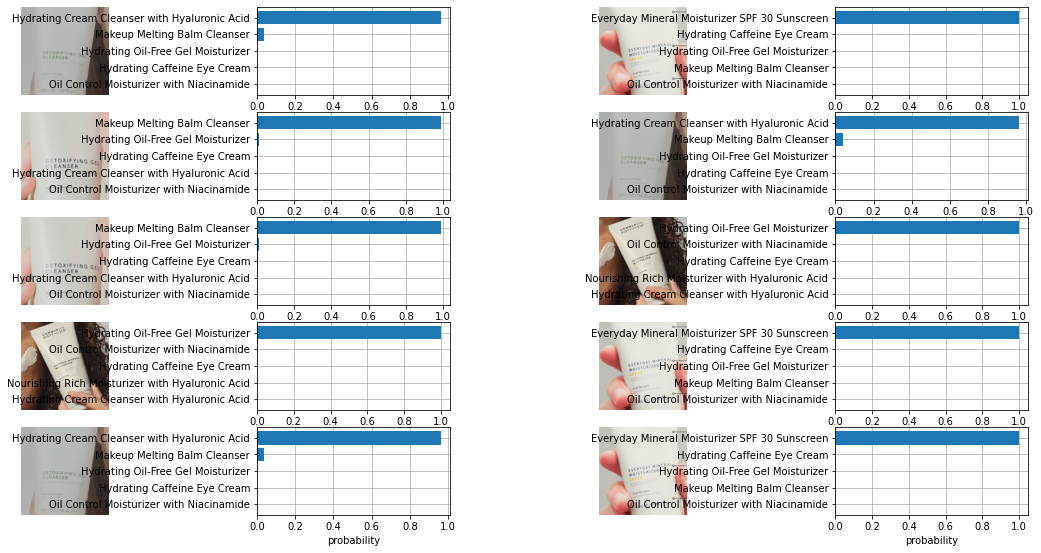

In [361]:
plt.figure(figsize=(19, 19))
#taking random index for random sampling
random_index = np.random.randint(len(image_input), size=10)
image_input_sample = [(image_input[x],x) for x in random_index] 
for i, image in enumerate(image_input_sample):
    plt.subplot(len(image_input_sample), 4, 2 * i + 1)
    #denormalizing the image and transforming to PIL image
    image_processed = denormalize(image[0].cpu())
    plt.imshow(transforms.ToPILImage()(image_processed))

    plt.axis("off")

    plt.subplot(len(image_input_sample), 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[image[1]])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [train_set.classes[index] for index in top_labels[image[1]].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

## Few shot